In this notebook, I will:
- data preprocessing
- convert text into embeddings
- visualization of embeddings
- utilize [Chroma](https://docs.trychroma.com/getting-started) as a vector search database
- the randomness in the search algorithm
- retrieve semantically similar documents to a query & visualize the results

Embedding means representing complex objects (like text, images, or sounds) as a numeric vector in a lower-dimensional space. This technique translates human-unstandable data into machine-readable format, enabling computation and analysis. 

In [79]:
import re
import json
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import openai
print("openai ver: ", openai.__version__)

openai ver:  1.3.4


## data preprocessing

In [3]:
df = pd.read_csv("data/data.csv").fillna("")
df.shape

(2500, 6)

In [4]:
df.sample(3)

category                       law  \
1508     票券金融            票券商對同一企業風險總額規定   
1154     票券金融           票券商負責人及業務人員管理規則   
2097     基層金融  信用合作社統一會計制度（一百零四年會計年度適用）   

                                                    url    created chapter  \
1508  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  092.01.21       4   
1154  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  090.12.26   第 6 條   
2097  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  086.12.24   第 2 條   

                                                   text  
1508  四、前點所列項目之風險權數如下：  (一) 對同一企業為短期票券之保證、背書，風險權數為百分...  
1154  票券金融公司副總經理、協理或與其職責相當者，應具備良好品德、領導 及有效經營票券金融公司之能...  
2097  信用合作社應依其會計事務之性質、業務實際狀況與發展，及管理上之需 要，訂定會計作業規範。 前...

In [5]:
df["len"] = df["text"].map(len)

In [6]:
df["len"].describe(percentiles=[0.99, 0.98, 0.95, 0.75, 0.25])

count     2500.000000
mean       246.626800
std        890.519129
min          4.000000
25%         54.000000
50%        113.000000
75%        237.000000
95%        679.050000
98%       1171.100000
99%       1751.030000
max      28742.000000
Name: len, dtype: float64

Some text are too long to be fed into embedding model directly. In such cases, let's split the text into multiple chunks.

In [7]:
df[df["len"] >= 2000].shape

(22, 7)

In [8]:
MAX_LEN = 2000
STRIDE = 1000
rows = []
for _, row in df.iterrows():
    if row["len"] <= MAX_LEN:
        rows.append(dict(row))
    else:
        part = 1
        chapter = row["chapter"]
        for i in range(0, row["len"], STRIDE):
            d = dict(row)
            d["text"] = row["text"][i: i+MAX_LEN]
            d["len"] = len(d["text"])
            d["chapter"] = chapter + f"_part_{part}"
            part += 1
            rows.append(d)
df_data = pd.DataFrame(rows)
df_data.shape

(2637, 7)

In [9]:
df_data[df_data["chapter"].str.contains("part")].shape

(159, 7)

In [10]:
df_data["len"].describe(percentiles=[0.99, 0.98, 0.95, 0.75, 0.25])

count    2637.000000
mean      281.279484
std       446.975460
min         4.000000
25%        57.000000
50%       121.000000
75%       270.000000
95%      1536.800000
98%      2000.000000
99%      2000.000000
max      2000.000000
Name: len, dtype: float64

In [13]:
df_data.tail(1)

category                  law  \
2636   金融控股公司  金融控股公司基本資料及財務資料申報報表   

                                                    url    created   chapter  \
2636  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  091.06.28  1_part_3   

                                                   text  len  
2636   │ │ │ │ │ │ 日期限結│ │ │ │ │ │ │ 構分析表│ │ │ │ │ │...  449

## convert text into embeddings

In [170]:
with open("key.txt") as fr:
    key = fr.read()

# initialize openai client
client = openai.OpenAI(api_key=key)

I will use [Openai Embeddings](https://platform.openai.com/docs/guides/embeddings).

However, there are several choices, such as [huggingface models](https://huggingface.co/models), [Sentence-Transformers](https://www.sbert.net/), [text2vec](https://github.com/shibing624/text2vec).

When utilizing embedding models, it's important to note the maximum length of text that a model can process.

In [167]:
def get_openai_emb(text, model_name="text-embedding-ada-002"):
    response = client.embeddings.create(
        input=text,
        model=model_name,
    )
    return response.data[0].embedding

In [14]:
# embs = {}

In [15]:
# in case of interruption, let's incorporate a retry mechanism to handle this situation.
for i, text in enumerate(df_data["text"]):
    if i in embs:
        continue
    if i % 200 == 0:
        print(f"{i} {datetime.now()}")
    count = 1
    while count <= 3: # retry
        try:
            e = get_openai_emb(text, model_name="text-embedding-3-small")
            embs[i] = e
            break
        except:
            print(f"  ** retry: {count}")
            count += 1
            time.sleep(3) # sleep more and retry
    time.sleep(1)
print("finished!")

0 2024-01-30 14:12:42.688112
200 2024-01-30 14:18:11.579711
400 2024-01-30 14:23:32.400492
600 2024-01-30 14:28:49.688051
800 2024-01-30 14:34:14.175851
1000 2024-01-30 14:46:10.336711
1200 2024-01-30 14:51:13.336920
1400 2024-01-30 14:56:15.657320
1600 2024-01-30 15:01:12.193327
1800 2024-01-30 15:06:14.806960
2000 2024-01-30 15:11:27.402745
2200 2024-01-30 15:16:44.953950
2400 2024-01-30 15:22:03.162385
2600 2024-01-30 15:27:19.937092
finished!


In [20]:
df_data["embedding"] = [embs[i] for i in range(df_data.shape[0])]

In [22]:
df_data.sample()

category             law  \
186       授信  加強本國銀行授信風險管理措施   

                                                   url    created chapter  \
186  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  102.01.07       4   

                                                  text  len  \
186  四、本國銀行於一百零三年十二月三十一日前符合下列第（一）款各項條  件者，得於一百零四年一月...  735   

                                             embedding  
186  [-0.013362700119614601, 0.039970412850379944, ...

In [23]:
# # Save for convenient future use
# df_data.to_pickle("data/data_emb.pickle")

In [5]:
df_data = pd.read_pickle("data/data_emb.pickle")
df_data.shape

(2637, 8)

## visualization of embeddings

In order to visualize high dimensional data, we can use dimension reduction algorithms like PCA, t-SNE, or UMAP to transform the data into 2 dimensional vector.

In this section, I will demonstrate how to plot data points in a 2-d graph using t-SNE and UMAP.

In [22]:
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import LabelEncoder

In [17]:
matrix = df_data["embedding"].to_list()
matrix = np.array(matrix)
matrix.shape

(2637, 1536)

In [23]:
# assign color to each category
colors = [
    "red", "darkorange", "gold", "turquoise", "darkgreen",
    "brown", "pink", "olive", "blue", "green"
]
colormap = matplotlib.colors.ListedColormap(colors)

# Utilize LabelEncoder() to quickly transform "label" to "id"
le = LabelEncoder()
cate_id = le.fit_transform(df_data["category"].values)
cate_id.shape

(2637,)

### t-SNE

In [7]:
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)

In [18]:
vis_dims = tsne.fit_transform(matrix)

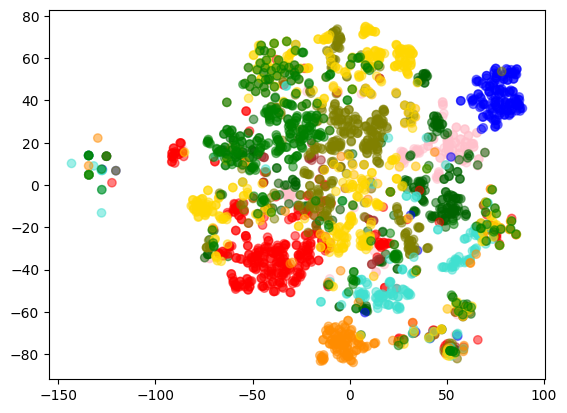

In [34]:
plt.scatter(vis_dims[:, 0], vis_dims[:, 1], c=cate_id, cmap=colormap, alpha=0.5)

we can also calculate the centriod of each category.

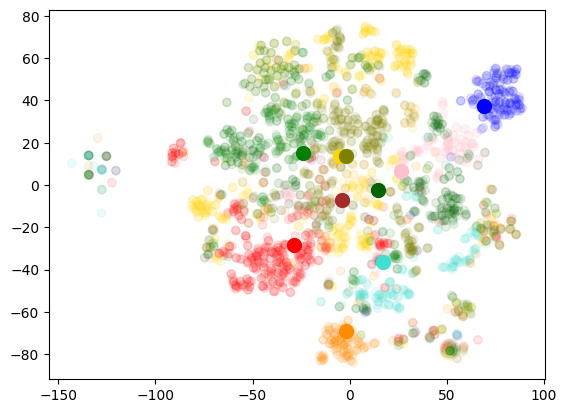

In [63]:
plt.scatter(vis_dims[:, 0], vis_dims[:, 1], c=cate_id, cmap=colormap, alpha=0.1)
for cate, group in df_data.groupby("category"):
    i = le.transform([cate])[0]
    color = colors[i]
    avg_x, avg_y = vis_dims[group.index].mean(axis=0)
    plt.scatter(avg_x, avg_y, marker="o", color=color, s=100)
# centroid of each category will be shown in the shape of "o"

### umap

In [65]:
umap_transform = umap.UMAP(
    random_state=0, transform_seed=0,
    n_neighbors=30, 
).fit(matrix)

/Users/chiachunlee/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [80]:
# batch transform will affect the results
u_dims = []
for i in tqdm(range(matrix.shape[0])):
    m = np.reshape(matrix[i], (1, -1))
    v = umap_transform.transform(m)[0]
    u_dims.append(v)
u_dims = np.array(u_dims)
u_dims.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2637/2637 [32:13<00:00,  1.36it/s]


(2637, 2)

In [81]:
u_dims

array([[ 8.899268 ,  2.0183363],
       [10.132655 ,  1.953741 ],
       [ 9.564831 ,  1.8264549],
       ...,
       [12.182698 ,  4.1594615],
       [12.099263 ,  4.225942 ],
       [12.075214 ,  4.4451027]], dtype=float32)

Text(0.5, 1.0, 'Projected Embeddings')

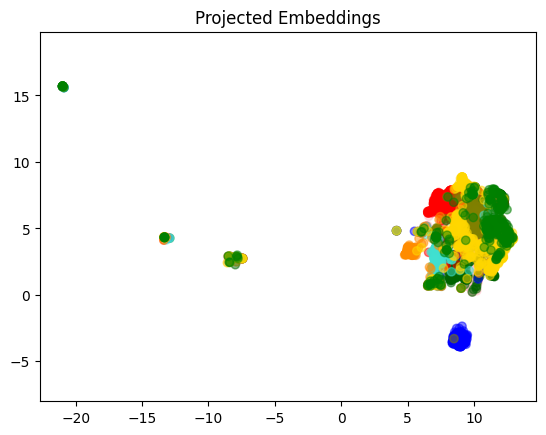

In [87]:
plt.scatter(u_dims[:, 0], u_dims[:, 1], c=cate_id, cmap=colormap, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Projected Embeddings")
# plt.axis("off")

Let's see the extremely far points.

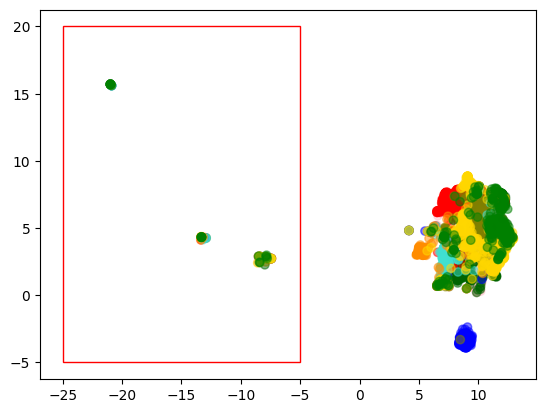

In [109]:
plt.scatter(u_dims[:, 0], u_dims[:, 1], c=cate_id, cmap=colormap, alpha=0.5)
# matplotlib.patches.Rectangle(xy, width, height, angle=0.0)
plt.gca().add_patch(
    matplotlib.patches.Rectangle((-25,-5),20,25,
    edgecolor="red",
    facecolor="none",
    lw=1))

In [97]:
# u_dims[u_dims[:, 0] < -5] # see the values
idx = np.where(u_dims[:, 0] < -5)[0] # see the indces
idx

array([   9,   19,   34,   41,   47,   53,   88,  107,  172,  250,  253,
        267,  276,  296,  304,  311,  321,  360,  388,  611,  613,  615,
        626,  628,  629,  712,  734,  738,  747,  762,  776,  782,  787,
        793,  816,  867,  877,  883,  916,  944,  950,  980,  994, 1052,
       1061, 1160, 1180, 1221, 1222, 1223, 1226, 1250, 1254, 1255, 1272,
       1282, 1291, 1304, 1314, 1321, 1334, 1349, 1367, 1379, 1391, 1401,
       1441, 1493, 1586, 1610, 1621, 1630, 1643, 1647, 1648, 1649, 1650,
       1652, 1657, 1658, 1659, 1660, 1661, 1662, 1674, 1681, 1687, 1693,
       1706, 1731, 1737, 1765, 1818, 1831, 1919, 1925, 1947, 1948, 1960,
       1966, 1977, 1994, 2009, 2062, 2073, 2082, 2083, 2094, 2113, 2124,
       2215, 2247, 2271, 2343, 2371, 2396, 2397, 2401, 2402, 2436, 2437,
       2441, 2453, 2468, 2476, 2480, 2482, 2536, 2545, 2557, 2564, 2575,
       2592, 2593, 2599])

In [99]:
df_data[df_data.index.isin(idx)][["category", "law", "text"]]

category                                    law  \
9          授信                          銀行業戰前存款放款清償條例   
19         授信  銀行業暨保險業辦理消費者信用交易廣告應揭示總費用範圍及年百分率計算方式標準   
34         授信                   金融機構辦理受災居民債務展延利息補貼辦法   
41         授信               信用合作社法準用銀行法第三十三條授權規定事項辦法   
47         授信                     銀行法第三十三條之三授權規定事項辦法   
...       ...                                    ...   
2564   金融控股公司             金融控股公司依金融控股公司法第四十六條申報與揭露辦法   
2575   金融控股公司                          金融控股公司發行公司債辦法   
2592   金融控股公司     金融控股公司發起人負責人應具備資格條件負責人兼職限制及應遵行事項準則   
2593   金融控股公司     金融控股公司發起人負責人應具備資格條件負責人兼職限制及應遵行事項準則   
2599   金融控股公司                         金融控股公司結合案件審查辦法   

                                                   text  
9                                            本條例自公布日施行。  
19                                 本標準自中華民國九十五年一月一日起施行。  
34                 本辦法自中華民國一百零四年八月六日施行。 本辦法修正條文，自發布日施行。  
41                                           本辦法自發布日施行。  
47                                           本辦法自發布日施行。  
...                                                 ...  
2564                                         本辦法自發布日施行。  
2575                               本辦法自中華民國一百十二年一月一日施行。  
2592                                               （刪除）  
2593  本準則自發布日施行。 中華民國一百零七年十月十二日修正條文第四條之一及第九條第二項至第 四項...  
2599                                         本辦法自發布日施行。  

[135 rows x 3 columns]

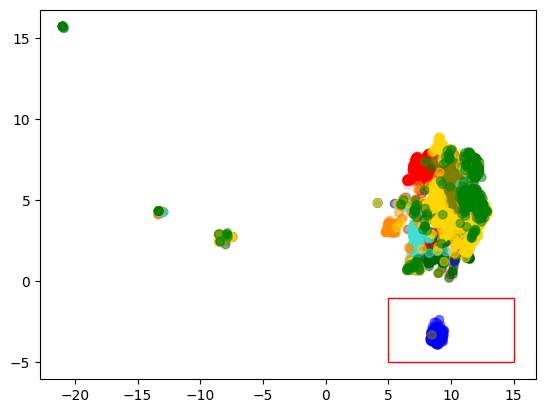

In [111]:
plt.scatter(u_dims[:, 0], u_dims[:, 1], c=cate_id, cmap=colormap, alpha=0.5)
# matplotlib.patches.Rectangle(xy, width, height, angle=0.0)
plt.gca().add_patch(
    matplotlib.patches.Rectangle((5,-5),10,4,
    edgecolor="red",
    facecolor="none",
    lw=1))

In [116]:
idx = np.where((u_dims[:, 0] > 5) & (u_dims[:, 1] <= -1))[0] # see the indces
idx

array([ 467,  468,  469,  470,  471,  472,  473,  474,  475,  476,  477,
        478,  479,  480,  481,  482,  483,  484,  485,  486,  487,  488,
        489,  490,  491,  492,  493,  494,  495,  496,  497,  498,  499,
        500,  501,  502,  503,  504,  505,  506,  507,  508,  509,  510,
        511,  512,  513,  514,  515,  516,  517,  518,  519,  520,  521,
        522,  523,  524,  525,  526,  527,  528,  529,  530,  531,  532,
        533,  534,  535,  536,  537,  538,  539,  540,  541,  542,  543,
        544,  545,  546,  547,  548,  549,  550,  551,  552,  553,  554,
        555,  556,  557,  558,  559,  560,  561,  562,  563,  564,  565,
        566,  567,  568,  569,  570,  571,  572,  573,  574,  575,  576,
        577,  578,  579,  580,  581,  582,  583,  584,  585,  586,  587,
        588,  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,
        599,  600,  601,  602,  603,  604,  605,  606,  607,  609,  610,
        616,  617,  618,  619,  620,  621,  623,  6

In [117]:
df_data[df_data.index.isin(idx)][["category", "law", "text"]]

category                   law  \
467        票據                   票據法   
468        票據                   票據法   
469        票據                   票據法   
470        票據                   票據法   
471        票據                   票據法   
...       ...                   ...   
625        票據               票據法施行細則   
627        票據               票據法施行細則   
631        票據          銀行簽發本行支票實施要點   
634        票據          銀行簽發本行支票實施要點   
1404     票券金融  短期票券發行登錄集中保管帳簿劃撥作業辦法   

                                                   text  
467                           （票據之種類） 本法所稱票據，為匯票、本票及支票。  
468   （匯票之定義） 稱匯票者，謂發票人簽發一定之金額，委託付款人於指定之到期日，無條 件支付與受...  
469   （本票之定義） 稱本票者，謂發票人簽發一定之金額，於指定之到期日，由自己無條件支 付與受款人...  
470   （支票、金融業之定義） 稱支票者，謂發票人簽發一定之金額，委託金融業者於見票時，無條件支 付...  
471         （簽名人責任） 在票據上簽名者，依票上所載文義負責。 二人以上共同簽名時，應連帶負責。  
...                                                 ...  
625                依本法第一百十三條規定，抄存於作成人事務所之拒絕證書，應載明匯票 全文。  
627                  依本法得為特約或約定之事項，非載明於票據，不得以之對抗善意第三人 。  
631                        一 本要點所稱本行支票，為銀行開具以本行為付款人之支票。  
634                           四 銀行簽發本行支票，應記載受款人，並加劃平行線。  
1404         基於商品交易或勞務提供而產生，且經受款人背書之本票或匯票之發行登 錄，不適用本辦法。  

[156 rows x 3 columns]

## utilize Chroma as a vector search database

In [120]:
import chromadb

In [121]:
chroma_client = chromadb.Client()

In [155]:
# delete collection
try:
    chroma_client.delete_collection("law")
except:
    pass

In [156]:
# create collectino
# will raise exception, if there already exists the same collection name
collection = chroma_client.create_collection(name="law")

In [157]:
ids = [str(i) for i in range(df_data.shape[0])]
metas = [
    {
        "law": r["law"],
        "category": r["category"],
        "chapter": r["chapter"],
        "url": r["url"],
    }
    for _, r in df_data.iterrows()
]
docs = df_data["text"].to_list()

In [158]:
# add documents
collection.add(
    documents=docs,
    metadatas=metas,
    ids=ids,
    embeddings=[r["embedding"] for _, r in df_data.iterrows()],
)

testing query relevant documents

In [159]:
i = 100
e = df_data.iloc[i]["embedding"]
df_data[i:i+1][["category", "law", "text"]]

category                         law  \
100       授信  銀行資產評估損失準備提列及逾期放款催收款呆帳處理辦法   

                                                  text  
100  逾期放款及催收款之轉銷，應經董 (理) 事會之決議通過，並通知監察人  (監事) 。但經主管...

In [160]:
# query documents
results = collection.query(query_embeddings=e, n_results=3)
results

{'ids': [['100', '1361', '2106']],
 'distances': [[0.0, 0.1981831192970276, 0.2165568321943283]],
 'metadatas': [[{'category': '授信',
    'chapter': '第 12 條',
    'law': '銀行資產評估損失準備提列及逾期放款催收款呆帳處理辦法',
    'url': 'https://law.banking.gov.tw/Chi/FSYS/../FLAW/FLAWDAT01.aspx?lsid=FL006396'},
   {'category': '票券金融',
    'chapter': '第 12 條',
    'law': '票券金融公司資產評估損失準備提列及逾期授信催收款呆帳處理辦法',
    'url': 'https://law.banking.gov.tw/Chi/FSYS/../FLAW/FLAWDAT01.aspx?lsid=FL006725'},
   {'category': '基層金融',
    'chapter': '第 12 條',
    'law': '信用合作社資產評估損失準備提列及逾期放款催收款呆帳處理辦法',
    'url': 'https://law.banking.gov.tw/Chi/FSYS/../FLAW/FLAWDAT01.aspx?lsid=FL006491'}]],
 'embeddings': None,
 'documents': [['逾期放款及催收款之轉銷，應經董 (理) 事會之決議通過，並通知監察人  (監事) 。但經主管機關或金融檢查機關 (構) 要求轉銷者，應即轉銷為 呆帳，並提報最近一次董 (理) 事會及通知監察人備查。董事會休會期間 ，得由常務董 (理) 事會代為行使，並通知監察人 (監事) ，再報董事會 備查。 前項規定，如其於授信或轉銷呆帳時，屬於銀行法第三十三條規定金額以 上之案件，應經三分之二以上董事之出席及出席董事四分之三以上之同意 。 外國銀行在台分行得依其總行授權程序辦理。',
   '逾期授信及催收款之轉銷，應經董事會之決議通過，並通知監察人。但經 主管機關要求轉銷者，應即轉銷為呆帳，並提報最近一次董事會及通知監 察

In [162]:
def wrap_outputs(results: dict) -> pd.DataFrame:
    # results: the output of chroma query
    metadata = results["metadatas"][0]
    return pd.DataFrame({
        "ids": results["ids"][0],
        "dist": results["distances"][0],
        "law": [m["law"] for m in metadata],
        "category": [m["category"] for m in metadata],
        "chapter": [m["chapter"] for m in metadata],
        "text": results["documents"][0],
        "url": [m["url"] for m in metadata],
    })

In [163]:
wrap_outputs(results)

ids      dist                             law category chapter  \
0   100  0.000000      銀行資產評估損失準備提列及逾期放款催收款呆帳處理辦法       授信  第 12 條   
1  1361  0.198183  票券金融公司資產評估損失準備提列及逾期授信催收款呆帳處理辦法     票券金融  第 12 條   
2  2106  0.216557   信用合作社資產評估損失準備提列及逾期放款催收款呆帳處理辦法     基層金融  第 12 條   

                                                text  \
0  逾期放款及催收款之轉銷，應經董 (理) 事會之決議通過，並通知監察人  (監事) 。但經主管...   
1  逾期授信及催收款之轉銷，應經董事會之決議通過，並通知監察人。但經 主管機關要求轉銷者，應即轉...   
2  逾期放款及催收款之轉銷，應經理事會之決議通過，並通知監事會。但經 主管機關或金融檢查機關 (...   

                                                 url  
0  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  
1  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  
2  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...

## the randomness in the search algorithm

When I was doing experiments on this dataset. I observed that the query results could be inconsistent with the same embedding. After done some research, I discovered that this inconsistency is due to the search algorithm, HNSW.

[This article](https://www.pinecone.io/learn/series/faiss/hnsw/) provider a clear explanation of the concept of HNSW. In summary, we can adjust certain parameters to reduct the randomness, as suggested [here](https://github.com/chroma-core/chroma/issues/860#issuecomment-1646959763).

```python
collection = chroma_client.create_collection(
    name="law",
    {
        "hnsw:construction_ef": 128,
        "hnsw:search_ef": 128,
        "hnsw:M": 128,
    }
)
```

## retrieve similar documents to a query

In [172]:
q = "災民貸款展延期限"
# Note that using the same model as the dataset
e = get_openai_emb(q, model_name="text-embedding-3-small")

In [175]:
results = collection.query(query_embeddings=e, n_results=20)
res = wrap_outputs(results)[:5]

In [178]:
res

ids      dist                   law category chapter  \
0  22  0.622592  金融機構辦理受災居民債務展延利息補貼辦法       授信   第 3 條   
1  26  0.657513  金融機構辦理受災居民債務展延利息補貼辦法       授信   第 7 條   
2  21  0.805338  金融機構辦理受災居民債務展延利息補貼辦法       授信   第 2 條   
3  25  0.870411  金融機構辦理受災居民債務展延利息補貼辦法       授信   第 6 條   
4  28  0.906947  金融機構辦理受災居民債務展延利息補貼辦法       授信   第 9 條   

                                                text  \
0  金融機構辦理受災居民各項貸款之展延期間如下： 一、本法第四十二條第一項以外之災區自用住宅購屋...   
1                   受災居民向金融機構申請債務展延之期間，自災害發生日起算一年屆止。   
2  本辦法之補貼範圍為金融機構就災害發生日前，受災居民對其所負之各項 債務，經辦理展延，於展延期...   
3  金融機構對受災居民債務展延之利息補貼，應檢具下列文件，向經理銀行 申請： 一、申請書或約定書...   
4  受災居民於債務展延期間內死亡，展延債務之法律關係因繼承由繼承人承 受者，金融機構得繼續依本辦...   

                                                 url  
0  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  
1  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  
2  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  
3  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...  
4  https://law.banking.gov.tw/Chi/FSYS/../FLAW/FL...

In [179]:
res.iloc[0]["text"]

'金融機構辦理受災居民各項貸款之展延期間如下： 一、本法第四十二條第一項以外之災區自用住宅購屋貸款： （一）房屋因災害毀損致不堪使用者，展延五年。 （二）房屋因災害部分毀損未致不堪使用者，展延二年。 二、災區非自用住宅購屋貸款其房屋因災害毀損致不堪使用，或部分毀損  未致不堪使用者，展延二年。 三、以災區之房屋為擔保之其他貸款及其他擔保貸款，展延一年。 四、汽車貸款，展延一年。 五、保險單借款、信用卡與現金卡應繳款項及其他無擔保貸款，展延六個  月。 六、債務協商債務，展延一年。 每筆債務之補貼期間，自災害發生日後金融機構與受災居民辦理展延之日 起，依前項展延期間計算。受災居民因受災害影響，自災害發生日後延遲 繳款者，經金融機構與受災居民雙方合意，展延期間之起算日得回溯自災 害發生日起算。'

The top1 result seems pretty relevant.

Let's visualize it.

This time, I'd like to remove points that are far away from main cluster from the graph in order to make the graph clearly.

In [193]:
idx1 = np.where(u_dims[:, 0] < -5)[0]
idx2 = np.where((u_dims[:, 0] > 5) & (u_dims[:, 1] <= -1))[0]
far_idx = np.concatenate((idx1, idx2))
far_idx.shape

(291,)

In [216]:
main = np.delete(u_dims, far_idx, axis=0)
main_cate_id = np.delete(cate_id, far_idx)

In [186]:
tx, ty = umap_transform.transform(np.array(e).reshape((1, -1)))[0]
tx, ty

(9.915671, 1.577636)

In [228]:
ids = [
    int(res.iloc[0]["ids"]),
    int(res.iloc[1]["ids"]),
    int(res.iloc[2]["ids"]),
]
x1, y1 = u_dims[ids[0]]
x2, y2 = u_dims[ids[1]]
x3, y3 = u_dims[ids[2]]

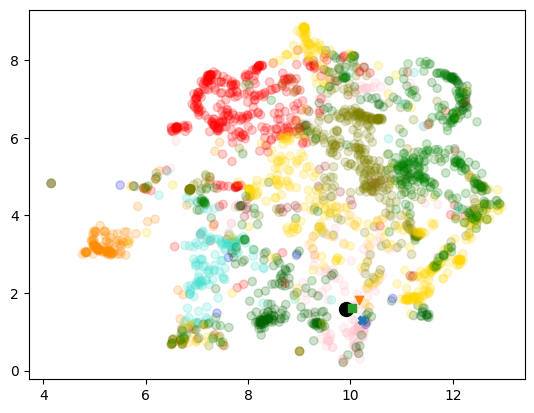

In [229]:
plt.scatter(main[:, 0], main[:, 1], c=main_cate_id, cmap=colormap, alpha=0.2)
plt.scatter(tx, ty, marker="o", color="black", s=100) # the query
plt.scatter(x1, y1, marker="X") # the top-1 doc, shown in filled-x
plt.scatter(x2, y2, marker="v") # the top-2 doc, shown in triangle_down
plt.scatter(x3, y3, marker="s") # the top-3 doc, shown in square

In a small dataset, we can calculate the similarity across all vectors.

In [230]:
from sklearn.metrics.pairwise import cosine_similarity

In [235]:
# the similarity between query and each vector
sim = cosine_similarity(np.array(e).reshape(1, -1), matrix)[0]
sim.shape

(2637,)

In [239]:
top_idx = np.argsort(sim)[::-1][:5]
top_score = np.sort(sim)[::-1][:5]
top_idx, top_score

(array([22, 26, 21, 25, 28]),
 array([0.68870406, 0.67124338, 0.59733099, 0.56479444, 0.54652656]))

In [241]:
df_data.loc[top_idx][["category", "law", "text"]]

category                   law  \
22       授信  金融機構辦理受災居民債務展延利息補貼辦法   
26       授信  金融機構辦理受災居民債務展延利息補貼辦法   
21       授信  金融機構辦理受災居民債務展延利息補貼辦法   
25       授信  金融機構辦理受災居民債務展延利息補貼辦法   
28       授信  金融機構辦理受災居民債務展延利息補貼辦法   

                                                 text  
22  金融機構辦理受災居民各項貸款之展延期間如下： 一、本法第四十二條第一項以外之災區自用住宅購屋...  
26                   受災居民向金融機構申請債務展延之期間，自災害發生日起算一年屆止。  
21  本辦法之補貼範圍為金融機構就災害發生日前，受災居民對其所負之各項 債務，經辦理展延，於展延期...  
25  金融機構對受災居民債務展延之利息補貼，應檢具下列文件，向經理銀行 申請： 一、申請書或約定書...  
28  受災居民於債務展延期間內死亡，展延債務之法律關係因繼承由繼承人承 受者，金融機構得繼續依本辦...